# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<br/>
October 2017

## Basic setup to run this yourself at NERSC ##

On cori.nersc.gov, clone two_percent_DESI:
```
git clone https://github.com/desihub/two_percent_DESI
```
At the time of this writing, this notebook is still in the "minitest" branch so switch to that:
```
cd two_percent_DESI
git checkout minitest
```
This notebook and its configuration files are in `two_percent_DESI/mini`.

Configure the desi-17.9 jupyter notebook kernel for your account following the instructions at
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC.  Then go to https://jupyter-dev.nersc.gov,
navigate to where you checked out `two_percent_DESI/mini` and start your own copy of this notebook.

To get the same version of code with an interactive login:
```console
source /project/projectdirs/desi/software/desi_environment.sh 17.9
```
(or `desi_environment.csh` for t/csh users)

### Notebook + Interactive Batch Jobs ###

Many steps are run directly in this notebook.  Some steps are slow enough that they benefit from using all the cores on 10-15 nodes.  In these cases, the notebook prints the commands for you to run from within an interactive batch session at NERSC.  The intension is that all steps can be run within an hour or so, but it isn't as simple as just Cell -> Run All.

In [1]:
import os, sys, glob
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
import desimodel.io
import desimodel.footprint
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/desi/dev/end2end/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |


In [2]:
basedir = os.path.join(os.environ['SCRATCH'], 'desi', 'dev', 'end2end')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
"""
else:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}



## Run survey simulations on a subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

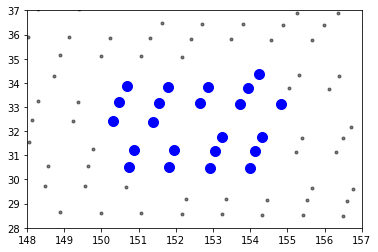

In [15]:
#- Make a subset of tiles to use
tiles = Table(desimodel.io.load_tiles())
ii = (150 < tiles['RA']) & (tiles['RA']<155) & (30<tiles['DEC']) & (tiles['DEC']<35)
clf()
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.5)
plot(tiles['RA'][ii], tiles['DEC'][ii], 'bo', ms=10)
xlim(148, 157); ylim(28, 37)
tiles_subset = tiles[ii]
tiles[ii].write('tiles-subset.fits', overwrite=True)

In [16]:
!time surveyinit --config-file ./desisurvey-config.yaml


real	0m10.787s
user	0m10.119s
sys	0m0.588s


In [17]:
#- Use 0d fiber assignment delay to move on with mini sim quickly
!time surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d


real	0m2.214s
user	0m1.610s
sys	0m0.587s


In [18]:
!time surveysim --config-file ./desisurvey-config.yaml --seed 123 >> $surveydir/survey.log


real	0m18.744s
user	0m18.249s
sys	0m0.448s


In [19]:
import subprocess
import time
plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
with open(os.path.join(surveydir, 'survey.log'), 'a') as logfile:
    while True:
        lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
        progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
        ndone = np.count_nonzero(progress['status'] == 2)
        print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
        if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break
        if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break

print('done observing all tiles')

Starting 2020-03-16 with 7/22 tiles completed Mon Oct 30 15:45:55 2017
Starting 2020-03-17 with 11/22 tiles completed Mon Oct 30 15:46:01 2017
Starting 2020-03-18 with 11/22 tiles completed Mon Oct 30 15:46:06 2017
Starting 2020-03-19 with 15/22 tiles completed Mon Oct 30 15:46:30 2017
Starting 2020-03-20 with 19/22 tiles completed Mon Oct 30 15:46:36 2017
Starting 2020-03-21 with 20/22 tiles completed Mon Oct 30 15:47:03 2017
Starting 2020-03-22 with 21/22 tiles completed Mon Oct 30 15:47:30 2017
Starting 2020-03-23 with 22/22 tiles completed Mon Oct 30 15:47:35 2017
done observing all tiles


In [20]:
!ls $surveydir

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-21.fits
last_date.txt			  plan_2020-03-22.fits
plan.fits			  progress.fits
plan_2020-03-15.fits		  progress_2020-03-16_bookmark.fits
plan_2020-03-16.fits		  progress_2020-03-17_bookmark.fits
plan_2020-03-16_bookmark.fits	  progress_2020-03-19_bookmark.fits
plan_2020-03-17.fits		  progress_2020-03-20_bookmark.fits
plan_2020-03-17_bookmark.fits	  scheduler.fits
plan_2020-03-18.fits		  stats.fits
plan_2020-03-19.fits		  survey.log
plan_2020-03-19_bookmark.fits	  surveyinit.fits
plan_2020-03-20.fits		  weather_123.fits
plan_2020-03-20_bookmark.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.

In [21]:
from desisurvey.progress import Progress
p = Progress(restore='progress.fits')
explist = p.get_exposures()
explist.write(os.path.join(surveydir, 'exposures.fits'), overwrite=True)

INFO:progress.py:133:__init__: Loaded progress from /global/cscratch1/sd/bweaver/desi/dev/end2end/survey/progress.fits.


In [22]:
tiles_subset['TILEID']

1148
1149
1165
6911
6927
11108
12689
16870
18451
18465
22632


In [23]:
explist['tileid']

34170
1165
1165
1149
1149
1148
1148
28394
28394
24227
24227


In [24]:
# Sanity check
assert np.all(np.in1d(tiles_subset['TILEID'], explist['tileid']))

## Study which healpixels cover those tiles

In [25]:
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

(28, 37)

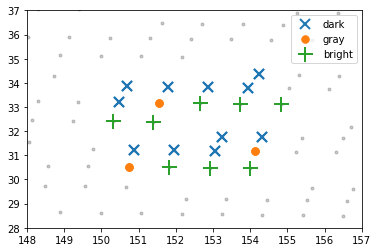

In [26]:
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['ra'][isdark], explist['dec'][isdark], 'x', ms=10, mew=2, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], '.', ms=15, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], '+', ms=15, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [27]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles_subset)
nexp = np.count_nonzero(np.in1d(explist['tileid'], tiles_subset['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles_subset), nexp, len(pixels)))

22 tiles covered by 28 exposures and 71 healpixels


In [28]:
pixels

array([5261, 5262, 5263, 5265, 5266, 5267, 5268, 5270, 5271, 5272, 5273,
       5274, 5275, 5276, 5277, 5278, 5279, 5281, 5283, 5284, 5285, 5286,
       5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300,
       5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311,
       5314, 5320, 5321, 5322, 5323, 5324, 5326, 5344, 5345, 5346, 5347,
       5348, 5350, 5352, 5353, 5354, 5355, 5356, 5636, 5637, 5648, 5649,
       5650, 5651, 5652, 5653, 5654])

(28, 37)

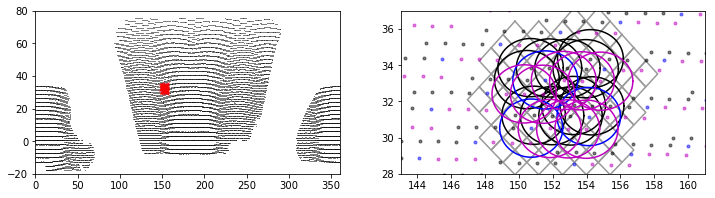

In [29]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

xtiles = tiles_subset
figure(figsize=(12,3))
subplot(121)
plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(xtiles['RA'], xtiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [30]:
#- Write subset of tiles table to file for input to mpi_select_mock_targets
tilefile = os.path.join(targetdir, 'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1148,154.23,34.35,0,1,0.0148942,1.02536,1397.33,1.12968,DARK,1
1149,153.23,31.77,0,1,0.0207369,1.0252,1372.21,1.17033,DARK,1
1165,150.69,33.86,0,1,0.0126537,1.02517,1416.73,1.11412,DARK,1
6911,154.32,31.75,1,1,0.0229261,1.02521,1401.19,1.18603,DARK,1
6927,151.78,33.84,1,1,0.0134791,1.02517,1402.3,1.11972,DARK,1
11108,150.87,31.23,1,1,0.0189035,1.02543,1451.67,1.15767,DARK,1
12689,152.87,33.82,2,1,0.0149298,1.02516,1390.24,1.12964,DARK,1
16870,151.96,31.21,2,1,0.0207586,1.02544,1403.42,1.17082,DARK,1
18451,153.95,33.8,3,1,0.0170573,1.02516,1406.78,1.14435,DARK,1


In [31]:
cmd = "srun -A desi -N 15 -n 30 -c 16 " # -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets --output_dir {targetdir} --config ./select-mock-targets.yaml"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
print('# Start an interactive job.')
print()
print('salloc -A desi -N 15 -t 00:30:00 -C haswell --qos interactive')
print()
print('# After your interactive node starts up,')
print('# cd to where ever you have two_percent_DESI/mini, then...')
print()
print(envcmd)
print(cmd)

# Start an interactive job.

salloc -A desi -N 15 -t 00:30:00 -C haswell --qos interactive

# After your interactive node starts up,
# cd to where ever you have two_percent_DESI/mini, then...

source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}

srun -A desi -N 15 -n 30 -c 16  mpi_select_mock_targets --output_dir /global/cscratch1/sd/bweaver/desi/dev/end2end/targets --config ./select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/test-tiles.fits


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [32]:
import glob
print("{} healpixels".format(len(pixels)))
for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
    filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
    print('{} {} files'.format(len(filenames), filetype))

71 healpixels
71 target files
71 truth files
71 sky files
71 standards-dark files
71 standards-bright files


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [33]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/bweaver/desi/dev/end2end/targets --force
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/sky.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/standards-dark.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/standards-bright.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/targets.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/truth.fits
INFO:build.py:1068:join_targets_truth: Generating merged target list /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.06859660148620605
DEBUG: calc_priority has 344534 unobserved targets
4 of 344534 targets have priority zero,

### Do some sanity checks on the results

In [34]:
targets = fitsio.read(os.path.join(targetdir, 'targets.fits'))
truth   = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl     = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std     = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

In [35]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


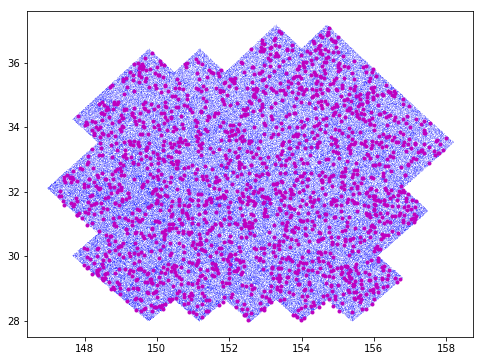

In [36]:
figure(figsize=(8,6))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

First, generate fiberassign configuration files pointing to the right inputs/outputs

In [37]:
#- Write list of tiles to consider
dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
for tileid, program  in zip(xtiles['TILEID'], xtiles['PROGRAM']):
    if program == 'BRIGHT':
        bx.write(str(tileid)+'\n')
    else:
        dx.write(str(tileid)+'\n')

dx.close()
bx.close()

#- Generate config files for dark and bright
cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
print(cmd)
!$cmd

cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
print(cmd)
!$cmd

config-fiberassign  --mtl /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/standards-dark.fits --sky /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/fiberassign-config-dark.txt
config-fiberassign  --mtl /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/standards-bright.fits --sky /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/fiberassign-config-bright.txt


#### Now run fiberassign itself ####
runs in <20 seconds for this subset of tiles

In [38]:
!rm -f $fibassigndir/tile_*.fits
!time fiberassign $fibassigndir/fiberassign-config-dark.txt > $fibassigndir/fa-dark.log
!time fiberassign $fibassigndir/fiberassign-config-bright.txt > $fibassigndir/fa-bright.log
!echo $(ls $fibassigndir/tile*.fits | wc -l) tile files created


real	0m7.465s
user	0m3.211s
sys	0m2.369s

real	0m6.262s
user	0m2.958s
sys	0m3.290s
22 tile files created


#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [39]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_01148.fits - ERROR
  Petal 3 has 7/10 stdstars
  Petal 5 has 8/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_01149.fits - ERROR
  1 unassigned fibers
  Petal 3 has 6/10 stdstars
  Petal 9 has 6/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_01165.fits - ERROR
  Petal 9 has 8/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_06911.fits - ERROR
  1 unassigned fibers
  Petal 0 has 6/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  Petal 5 has 5/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_11108.fits - ERROR
  2 unassigned fibers
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_12689.fits - ERROR
  1 unassigned fibers
  Petal 8 has 7/10 stdstars
  Petal 9 has 9/10 stdstars
/global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign/tile_16870.fits - OK
/global

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

7.4 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes.

In [40]:
# cmd = "srun -N 4 -n 4 -c 32 -C haswell -p debug -t 00:30:00 --qos premium "
nodes = 15

print('# Start an interactive job.')
print()
print('salloc -A desi -N {nodes} -C haswell -t 0:30:00 --qos interactive'.format(nodes=nodes))
print()
print('# After your interactive node starts up, set the environment ...')
print()
print(envcmd)
print()
print("# Then run this in the interactive node:")
print()
cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
cmd += " --mockdir {}".format(targetdir)
cmd += " --obslist {}/exposures.fits".format(surveydir)
cmd += " --tilefile {}".format(tilefile)
print(cmd)

# Start an interactive job.

salloc -A desi -N 15 -C haswell -t 0:30:00 --qos interactive

# After your interactive node starts up, set the environment ...

source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}


# Then run this in the interactive node:

srun -A desi -N 15 -n 15 -c 32 wrap-newexp --mpi --fiberassign /global/cscratch1/sd/bweaver/desi/dev/end2end/fiberassign --mockdir /global/cscratch1/sd/bweaver/desi/dev/end2end/targets --obslist /global/cscratch1/sd/bweaver/desi/dev/end2end/survey/exposures.fits --tilefile /global/cscratch1/sd/bweaver/desi/dev/end2end/targets/test-tiles.fits


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

9.6 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes

In [41]:
cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 wrap-fastframe --mpi".format(nodes=nodes)
print('#- From the same interactive job where you ran wrap-newexp, run this:')
print(cmd)

#- From the same interactive job where you ran wrap-newexp, run this:
srun -A desi -N 15 -n 15 -c 32 wrap-fastframe --mpi


## Run the spectro pipeline

  * generate the production scripts
  * launch them

The pipeline massively overestimates the time to run each step, so at submission time dial the time back to just 10 minutes.

In [42]:
#- Equivalent to running `desi_pipe` from the command line with no arguments
#- Detail: have to provide blank string or otherwise it uses sys.argv which has
#- leftover args from launching jupyter
from desispec.scripts import pipe_prod
args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
pipe_prod.main(args)

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Working with production /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 16 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
65 minutes too big 

In [43]:
#- Find nights that observed these tiles
nights = unique(np.char.replace(np.char.decode(explist['night']), '-', ''))
print(nights)

['20200315' '20200316' '20200318' '20200319' '20200320' '20200321'
 '20200322']


In [44]:
for night in nights:
    launchcmd = 'sbatch -A desi --time 00:10:00 {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
        reduxdir=reduxdir, night=night
    )
    print(launchcmd)
    err = subprocess.call(launchcmd.split())
    if err != 0:
        print('ERROR {} while launching {}'.format(err, night))

sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200315/fiberflat-calibrate_20200315.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200316/fiberflat-calibrate_20200316.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200318/fiberflat-calibrate_20200318.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200319/fiberflat-calibrate_20200319.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200320/fiberflat-calibrate_20200320.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/run/scripts/20200321/fiberflat-calibrate_20200321.slurm
sbatch -A desi --time 00:10:00 /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/red

### Monitor those jobs until they have all completed

In [45]:
qq = 'squeue -u {USER}'.format(**os.environ)
print(qq)
!$qq

squeue -u bweaver
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7943538   regular fiberfla  bweaver PD       0:00     25 (Priority)
           7943539   regular fiberfla  bweaver PD       0:00     14 (Priority)
           7943540   regular fiberfla  bweaver PD       0:00     12 (Priority)
           7943541   regular fiberfla  bweaver PD       0:00     14 (None)
           7943542   regular fiberfla  bweaver PD       0:00      2 (Priority)
           7943543   regular fiberfla  bweaver PD       0:00      2 (Priority)
           7943544   regular fiberfla  bweaver PD       0:00      2 (None)


### Check that we got expected outputs
This includes both calibration and science exposures

In [46]:
ii = np.in1d(explist['tileid'], xtiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

frame 1710/1710, cframe 1080/1080


## Regroup spectra from frames -> healpix

This script is asking for 1 node for 2 hours (!).  Try running as interactive job on 10 nodes.  That took ~40 minutes.

Retrospective Note: the code probably uses 1 rank per healpix, in which case 160 ranks is a waste for ~70 healpix...

In [48]:
#- Equivalent to running `desi_group_spectra --hpxnside 64` from command line (this is slow)
# from desispec.scripts import group_spectra
# args = group_spectra.parse('--hpxnside 64'.split())
# group_spectra.main(args)

#- To run as a batch job instead (including MPI parallelism)

print('#- From a cori.nersc.gov login node with environment set as for previous interactive jobs')
print('salloc -A desi -N 10 -t 1:00:00 -C haswell --qos interactive')
if 'csh' in os.environ['SHELL']:
    print('setenv TMPDIR /dev/shm')
else:
    print('export TMPDIR=/dev/shm')
print('srun -A desi --cpu_bind=cores -N 10 -n 160 -c 4 desi_group_spectra --pipeline')
# cmd = 'sbatch {}/run/scripts/spectra.slurm'.format(reduxdir)
# print(cmd)
# !$cmd

#- From a cori.nersc.gov login node with environment set as for previous interactive jobs
salloc -A desi -N 10 -t 1:00:00 -C haswell --qos interactive
setenv TMPDIR /dev/shm
srun -A desi --cpu_bind=cores -N 10 -n 160 -c 4 desi_group_spectra --pipeline


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5265.fits
Missing spectra-64-5268.fits
Missing spectra-64-5324.fits
Missing spectra-64-5636.fits


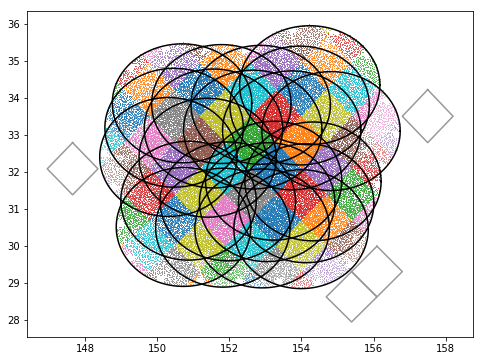

In [49]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in xtiles:
    plot_tile(t['RA'], t['DEC'])

## Run redrock redshift fitting

desispec/0.16.0 has a bug in how spectra are distributed over MPI ranks for the pipeline wrapper of redrock.
Bypass this by using the `two_percent_DESI/mini/wrap-redrock` script.
```
# on a cori.nersc.gov login node,
# execute the environment setup commands at the beginning of this notebook (output of code cell #2)
# cd to your git repo for two_percent_DESI/mini, then run
salloc -A desi -N 15 -t 2:00:00 -C haswell --qos interactive
time srun -A desi -N 15 -n 15 -c 64 ./wrap-redrock --mpi --ncpu 24
```

### Check redrock output

In [3]:
import desitarget.io
zbestfiles = list(desitarget.io.iter_files(reduxdir, 'zbest'))
print('{} zbest files'.format(len(zbestfiles)))

63 zbest files


#### Sort bricks by number of targets

In [5]:
import desispec.io

specdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm)
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))
print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5261.fits   147      146
spectra-64-5262.fits   148       96
spectra-64-5263.fits  1614     1179
spectra-64-5266.fits   140      140
spectra-64-5267.fits   611      545
spectra-64-5270.fits  1077      745
spectra-64-5271.fits   571      331
spectra-64-5272.fits  1333     1192
spectra-64-5273.fits  3200     2021
spectra-64-5274.fits  4224     2501
spectra-64-5275.fits  6243     3172
spectra-64-5276.fits  3920     2055
spectra-64-5277.fits  2785     1517
spectra-64-5278.fits  5432     2752
spectra-64-5279.fits  4700     2521
spectra-64-5281.fits    40       20
spectra-64-5283.fits   172       86
spectra-64-5284.fits  1306      746
spectra-64-5285.fits  3512     1918
spectra-64-5286.fits  1729      892
spectra-64-5287.fits  3425     1893
spectra-64-5289.fits    14        7
spectra-64-5292.fits  1193      591
spectra-64-5293.fits  3024     1772
spectra-64-5294.fits    41  

## Create zcatalog

**TODO**: fix trailing space in TRUESPECTYPE, SPECTYPE

In [6]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/bweaver/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


In [7]:
## Redshift QA
truth = Table.read(os.path.join(targetdir, 'truth.fits'))
zcat = Table.read(os.path.join(reduxdir, 'zcatalog.fits'))

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [8]:
import astropy.table
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [9]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  4453
LRG  7907
ELG  30095
STAR 6809
BGS  26479


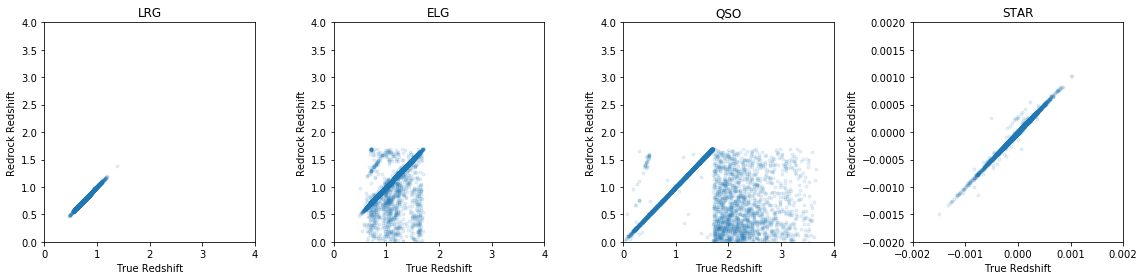

In [10]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [11]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('          ntarg   good  fail  miss  lost')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = (ztruth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
QSO        4453   60.6   2.1   0.7  36.6
STAR       6809   91.0   0.2   1.4   7.4
BGS       26479   99.7   0.1   0.2   0.0
LRG        7907  100.0   0.0   0.0   0.0
WD          154   90.9   5.8   0.6   2.6
ELG       30095   92.2   0.3   3.9   3.5

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## What happened to the high-z QSOs?

This is a bug in the QSO template generation in desispec 16.0

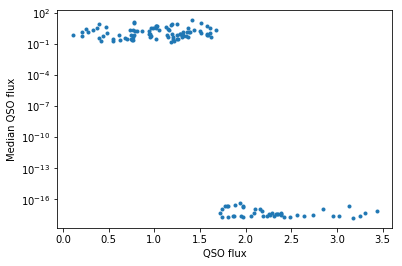

In [13]:
from astropy.io import fits
targetfile = os.path.join(targetdir, '53', '5300', 'truth-64-5300.fits')
xflux = fits.getdata(targetfile, 'FLUX')
xtrue = Table.read(targetfile, 'TRUTH')
isqso = xtrue['TRUESPECTYPE'] == 'QSO'
xflux = xflux[isqso]
xtrue = xtrue[isqso]
tmpflux = np.median(xflux, axis=1)

plot(xtrue['TRUEZ'], tmpflux, '.')
semilogy()
xlabel('QSO flux'); ylabel('Median QSO flux')

## Study QSO efficiency vs. FLUX_G

The failures are dominated by z>1.7 input spectra with the wrong flux units, but the lowz QSOs
are so efficient that is isn't very meaningful to bin them.  Leaving this code in here for now in case it is useful in a later update.

In [14]:
g = ztruth['FLUX_G']
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5   15 QSO     86.7   6.7   0.0   6.7
16.5-17.0   17 QSO     82.4   0.0   0.0  17.6
17.0-17.5   12 QSO     83.3   8.3   0.0   8.3
17.5-18.0   16 QSO     87.5   0.0   6.2   6.2
18.0-18.5    9 QSO     88.9   0.0   0.0  11.1
18.5-19.0   13 QSO     69.2   7.7   0.0  23.1
19.0-19.5    6 QSO     66.7   0.0   0.0  33.3
19.5-20.0    8 QSO     62.5  12.5   0.0  25.0
20.0-20.5    9 QSO     88.9   0.0   0.0  11.1
20.5-21.0    7 QSO     85.7   0.0   0.0  14.3
21.0-21.5    6 QSO     83.3   0.0   0.0  16.7
21.5-22.0    7 QSO     57.1   0.0   0.0  42.9
22.0-22.5    8 QSO     87.5   0.0   0.0  12.5
22.5-23.0    7 QSO     71.4   0.0   0.0  28.6
23.0-23.5   11 QSO     72.7   0.0   0.0  27.3
23.5-24.0   11 QSO     81.8   0.0   0.0  18.2


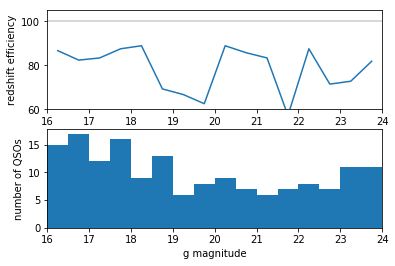

In [15]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

# TODO

A wishlist of things to add to this notebook (but not necessarily blocking factors for merging)
* Target selection QA
* spectro pipeline QA
* other QA?